 # **<font color='blue'/>Importation des packages et chargement des données**

---



Importation des packages

In [1]:
pip install googletrans==4.0.0-rc1

In [2]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

import datetime as dt
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta

import matplotlib as mpl

from googletrans import Translator, constants

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.datasets import make_blobs

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import adjusted_rand_score
from sklearn.ensemble import IsolationForest

import pickle as pk
import os

chargement des données

In [5]:
df_geo      = pd.read_csv("Data/olist_geolocation_dataset.csv")
df_customer = pd.read_csv("Data/olist_customers_dataset.csv")
df_item     = pd.read_csv("Data/olist_order_items_dataset.csv")
df_payment  = pd.read_csv("Data/olist_order_payments_dataset.csv")
df_review   = pd.read_csv("Data/olist_order_reviews_dataset.csv")
df_order    = pd.read_csv("Data/olist_orders_dataset.csv")
df_product  = pd.read_csv("Data/olist_products_dataset.csv")
df_seller   = pd.read_csv("Data/olist_sellers_dataset.csv")
df_category = pd.read_csv("Data/product_category_name_translation.csv")

# **<font color='blue'/>Nettoyage des données**

---



Afficher la dimensionnalité des DataFrames.

In [6]:
print('df_geo      : ',df_geo.shape)   
print('df_customer : ',df_customer.shape)
print('df_item     : ',df_item.shape)
print('df_payment  : ',df_payment.shape)
print('df_review   : ',df_review.shape)
print('df_order    : ',df_order.shape)
print('df_product  : ',df_product.shape)
print('df_seller   : ',df_seller.shape)
print('df_category : ',df_category.shape)

df_geo      :  (1000163, 5)
df_customer :  (99441, 5)
df_item     :  (112650, 7)
df_payment  :  (103886, 5)
df_review   :  (99224, 7)
df_order    :  (99441, 8)
df_product  :  (32951, 9)
df_seller   :  (3095, 4)
df_category :  (71, 2)


Afficher les clonnes des DataFrames

In [7]:
print('df_geo      : ',df_geo.columns)   
print('df_customer : ',df_customer.columns)
print('df_item     : ',df_item.columns)
print('df_payment  : ',df_payment.columns)
print('df_review   : ',df_review.columns)
print('df_order    : ',df_order.columns)
print('df_product  : ',df_product.columns)
print('df_seller   : ',df_seller.columns)
print('df_category : ',df_category.columns)

df_geo      :  Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')
df_customer :  Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')
df_item     :  Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')
df_payment  :  Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')
df_review   :  Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')
df_order    :  Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer

Tranduire les catégories du portugais au français

In [8]:
# init the Google API translator
translator = Translator()

df_category['product_category_name_fr'] = df_category['product_category_name_english'].str.replace('_', ' ').apply(translator.translate, src='en',dest='fr').apply(getattr, args=('text',))
df_category.head(20)

product_category_name product_category_name_english  \
0                  beleza_saude                 health_beauty   
1        informatica_acessorios         computers_accessories   
2                    automotivo                          auto   
3               cama_mesa_banho                bed_bath_table   
4              moveis_decoracao               furniture_decor   
5                 esporte_lazer                sports_leisure   
6                    perfumaria                     perfumery   
7         utilidades_domesticas                    housewares   
8                     telefonia                     telephony   
9            relogios_presentes                 watches_gifts   
10            alimentos_bebidas                    food_drink   
11                        bebes                          baby   
12                    papelaria                    stationery   
13     tablets_impressao_imagem        tablets_printing_image   
14                   brinquedos                          toys   
15               telefonia_fixa               fixed_telephony   
16           ferramentas_jardim                  garden_tools   
17  fashion_bolsas_e_acessorios      fashion_bags_accessories   
18              eletroportateis              small_appliances   
19               consoles_games                consoles_games   

        product_category_name_fr  
0                 Santé & Beauté  
1      Accessoires d'ordinateurs  
2                           auto  
3           table de bain de lit  
4               décor de meubles  
5                 loisir sportif  
6                     parfumerie  
7                       ménagère  
8                     téléphonie  
9                Montres cadeaux  
10            nourriture boisson  
11                       de bébé  
12                     papeterie  
13  comprimés image d'impression  
14                        jouets  
15               téléphonie fixe  
16              outils de jardin  
17   Accessoires de sacs de mode  
18              petits appareils  
19              Jeux de consoles

fusionner toutes les données dans une dataframe

In [9]:
df_olist = pd.DataFrame()
df_olist = df_order.merge(df_customer, on='customer_id', how='left')
df_olist = df_olist.merge(df_item, on='order_id', how='outer')
df_olist = df_olist.merge(df_review, on='order_id', how='outer')
df_olist = df_olist.merge(df_product, on='product_id', how='outer')
df_olist = df_olist.merge(df_category, on='product_category_name', how='outer')
df_olist = df_olist.merge(df_seller, on='seller_id', how='outer')

In [10]:
df_olist.shape

(114092, 37)

Afficher les informations du Datafarme

In [11]:
df_olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114092 entries, 0 to 114091
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       114092 non-null  object 
 1   customer_id                    114092 non-null  object 
 2   order_status                   114092 non-null  object 
 3   order_purchase_timestamp       114092 non-null  object 
 4   order_approved_at              113930 non-null  object 
 5   order_delivered_carrier_date   112112 non-null  object 
 6   order_delivered_customer_date  110839 non-null  object 
 7   order_estimated_delivery_date  114092 non-null  object 
 8   customer_unique_id             114092 non-null  object 
 9   customer_zip_code_prefix       114092 non-null  int64  
 10  customer_city                  114092 non-null  object 
 11  customer_state                 114092 non-null  object 
 12  order_item_id                 

Trier les colonnes

In [12]:
col_olis = ['order_id', 'customer_id', 'customer_unique_id', 'product_id', 'seller_id', 
'review_id', 'order_item_id', 'price', 'order_status',
'customer_zip_code_prefix', 'customer_city', 'customer_state', 'review_score', 'review_comment_title', 
'review_comment_message', 'freight_value', 'product_category_name', 'product_category_name_english', 'product_category_name_fr', 
'product_photos_qty', 'seller_zip_code_prefix', 'seller_city', 'seller_state',
'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
'order_delivered_customer_date', 'order_estimated_delivery_date',
'review_creation_date', 'review_answer_timestamp', 'shipping_limit_date']

df_olist = df_olist[col_olis]

 Afficher les informations du Datafarme

In [13]:
df_olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114092 entries, 0 to 114091
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       114092 non-null  object 
 1   customer_id                    114092 non-null  object 
 2   customer_unique_id             114092 non-null  object 
 3   product_id                     113314 non-null  object 
 4   seller_id                      113314 non-null  object 
 5   review_id                      113131 non-null  object 
 6   order_item_id                  113314 non-null  float64
 7   price                          113314 non-null  float64
 8   order_status                   114092 non-null  object 
 9   customer_zip_code_prefix       114092 non-null  int64  
 10  customer_city                  114092 non-null  object 
 11  customer_state                 114092 non-null  object 
 12  review_score                  

Convertir les colonnes date en format date

In [14]:
col_date = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
            'order_delivered_customer_date', 'order_estimated_delivery_date',
            'review_creation_date', 'review_answer_timestamp', 'shipping_limit_date']

df_olist[col_date] = df_olist[col_date].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

df_olist[col_date].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114092 entries, 0 to 114091
Data columns (total 8 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_purchase_timestamp       114092 non-null  datetime64[ns]
 1   order_approved_at              113930 non-null  datetime64[ns]
 2   order_delivered_carrier_date   112112 non-null  datetime64[ns]
 3   order_delivered_customer_date  110839 non-null  datetime64[ns]
 4   order_estimated_delivery_date  114092 non-null  datetime64[ns]
 5   review_creation_date           113131 non-null  datetime64[ns]
 6   review_answer_timestamp        113131 non-null  datetime64[ns]
 7   shipping_limit_date            113314 non-null  datetime64[ns]
dtypes: datetime64[ns](8)
memory usage: 7.8 MB


Arrondir les valeurs à deux décimales

In [15]:
pd.options.display.float_format = '{:.2f}'.format

Les statistiques descriptives des données

In [16]:
df_olist.describe()

order_item_id     price  customer_zip_code_prefix  review_score  \
count      113314.00 113314.00                 114092.00     113131.00   
mean            1.20    120.48                  35105.23          4.02   
std             0.71    183.28                  29868.30          1.40   
min             1.00      0.85                   1003.00          1.00   
25%             1.00     39.90                  11250.00          4.00   
50%             1.00     74.90                  24320.00          5.00   
75%             1.00    134.90                  59022.00          5.00   
max            21.00   6735.00                  99990.00          5.00   

       freight_value  product_photos_qty  seller_zip_code_prefix  
count      113314.00           111702.00               113314.00  
mean           19.98                2.21                24441.67  
std            15.78                1.72                27597.24  
min             0.00                1.00                 1001.00  
25%            13.08                1.00                 6429.00  
50%            16.26                1.00                13568.00  
75%            21.15                3.00                27930.00  
max           409.68               20.00                99730.00

Afficher les clients avec les lignes dupliquées

In [17]:
df_olist[df_olist['customer_unique_id'].duplicated()].sort_values(by='customer_unique_id', ascending=True)

order_id                       customer_id  \
91397   44e608f2db00c74a1fe329de44416a4e  a81ebb9b32f102298c0c89635b4b3154   
111673  fd61441ba2a7b57e6342862e779b10b0  e36917a47d5bf39bd3f38bcafb3d438f   
75069   c6d61340bd8baeedca7cc8e7f7ec07e9  455f2e2988eaf87d7e2ba33b0a57969f   
15446   87440e08790d85796f5b8bc9f5ed2707  4b95f958af9c866353ae1108d8ebd023   
93678   87440e08790d85796f5b8bc9f5ed2707  4b95f958af9c866353ae1108d8ebd023   
...                                  ...                               ...   
85319   cf4659487be50c0c317cff3564c4a840  ed583a2a1eaf0dedc33af816153e8b8c   
85320   cf4659487be50c0c317cff3564c4a840  ed583a2a1eaf0dedc33af816153e8b8c   
85321   cf4659487be50c0c317cff3564c4a840  ed583a2a1eaf0dedc33af816153e8b8c   
49539   2c43da70769acf988d27b050b189c7fe  7aa03a53e8c6489f3854470b6ebe9537   
98992   725cf8e9c24e679a8a5a32cb92c9ce1e  74be082247cd677a147d83ee670e9d53   

                      customer_unique_id                        product_id  \
91397   00053a61a98854899e70ed204dd4bafe  62984ea1bba7fcea1f5b57084d3bf885   
111673  000bfa1d2f1a41876493be685390d6d3  bb15f9ba2ec6e36ab6c9e88d17430d64   
75069   000de6019bb59f34c099a907c151d855  9e572ff4654f7064419d97a891a8b0fc   
15446   000fbf0473c10fc1ab6f8d2d286ce20c  38021cef829efa264df6f9d21c4df6e9   
93678   000fbf0473c10fc1ab6f8d2d286ce20c  d7a3cfa08519494aa1ad181e803617ec   
...                                  ...                               ...   
85319   fff5eb4918b2bf4b2da476788d42051c  bc3c6d2a621414f2e1df7a8a32a2828e   
85320   fff5eb4918b2bf4b2da476788d42051c  bc3c6d2a621414f2e1df7a8a32a2828e   
85321   fff5eb4918b2bf4b2da476788d42051c  bc3c6d2a621414f2e1df7a8a32a2828e   
49539   fff7219c86179ca6441b8f37823ba3d3  592962829d5a715304344e656e39108a   
98992   fffcf5a5ff07b0908bd4e2dbc735a684  c100e5fef1abb5e1c5054d1dac2d83ac   

                               seller_id                         review_id  \
91397   218d46b86c1881d022bce9c68a7d4b15  333a6ca3cdb01f5f00e3e6be1f1236e1   
111673  b372ee768ed69e46ca8cdbd267aa7a38  24ad2fc85ec000ba4fbfd9841d9a1972   
75069   da8622b14eb17ae2831f4ac5b9dab84a  49af8d8f5a31674c3474ab9ea125db04   
15446   ce248b21cb2adc36282ede306b7660e5  b6ebd8ff503e058bc1205ee501274c1a   
93678   e53d5b9b29d1218281f4a907ada18626  b6ebd8ff503e058bc1205ee501274c1a   
...                                  ...                               ...   
85319   56e361f411e38dcef17cdc2a3d99628b  b119d1bd982320419b7aa6f12b42b9d9   
85320   56e361f411e38dcef17cdc2a3d99628b  b119d1bd982320419b7aa6f12b42b9d9   
85321   56e361f411e38dcef17cdc2a3d99628b  b119d1bd982320419b7aa6f12b42b9d9   
49539   8160255418d5aaa7dbdc9f4c64ebda44  2e32db59a88732a2786772f77576b712   
98992   17f51e7198701186712e53a39c564617  bf0bcc92778d81c81f4e270732edcee6   

        order_item_id  price order_status  customer_zip_code_prefix  ...  \
91397            1.00 191.00    delivered                     80410  ...   
111673           1.00  35.00    delivered                     11095  ...   
75069            2.00 139.90    delivered                     11612  ...   
15446            2.00 119.87    delivered                     13330  ...   
93678            3.00  23.03    delivered                     13330  ...   
...               ...    ...          ...                       ...  ...   
85319            4.00 175.00    delivered                     58407  ...   
85320            5.00 175.00    delivered                     58407  ...   
85321            6.00 175.00    delivered                     58407  ...   
49539            1.00 122.90    delivered                     28680  ...   
98992            1.00 890.00    delivered                     55250  ...   

                  seller_city seller_state  order_purchase_timestamp  \
91397          ribeirao preto           SP       2018-02-28 11:15:41   
111673  sao jose do rio preto           SP       2017-09-29 14:46:58   
75069              piracicaba           SP       2017-08-17 19:10:33   
15446          jarag

Le taux de valeurs manquantes en %

In [18]:
missing_rate = (df_olist.isna().sum()/df_olist.shape[0])*100
missing_rate

order_id                         0.00
customer_id                      0.00
customer_unique_id               0.00
product_id                       0.68
seller_id                        0.68
review_id                        0.84
order_item_id                    0.68
price                            0.68
order_status                     0.00
customer_zip_code_prefix         0.00
customer_city                    0.00
customer_state                   0.00
review_score                     0.84
review_comment_title            88.15
review_comment_message          57.78
freight_value                    0.68
product_category_name            2.09
product_category_name_english    2.12
product_category_name_fr         2.12
product_photos_qty               2.09
seller_zip_code_prefix           0.68
seller_city                      0.68
seller_state                     0.68
order_purchase_timestamp         0.00
order_approved_at                0.14
order_delivered_carrier_date     1.74
order_delive

Graphique du taux de valeurs manquantes

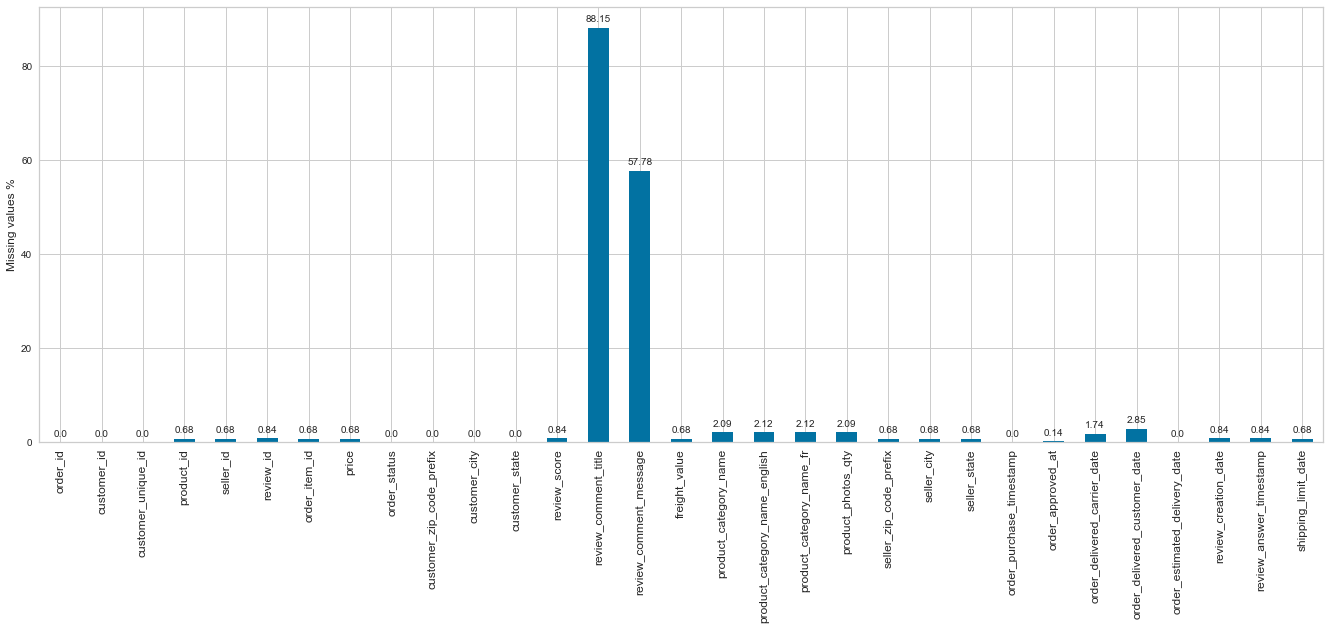

In [19]:
missing_rate = pd.DataFrame(missing_rate)
ax = missing_rate.plot.bar(figsize=(23,8))

ax.set_ylabel("Missing values %", fontsize=12)

plt.xticks(rotation='90', fontsize=12)

plt.legend().set_visible(False)

# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.annotate(np.round(p.get_height(),decimals=2),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 8),
                textcoords='offset points',
                fontsize = 10,
                )

Remplir les valeurs manquantes de la colonne 'review_comment_title'

In [20]:
df_olist['review_comment_title'].fillna(value= 'Aucun titre de commentaire', inplace=True)

Remplir les valeurs manquantes de la colonne 'review_comment_message'

In [21]:
df_olist['review_comment_message'].fillna(value= 'Aucun commentaire', inplace=True)

Remplir les valeurs manquantes de la colonne 'product_photos_qty' par 0

In [22]:
df_olist['product_photos_qty'].fillna(value= 0, inplace=True)

Remplir les valeurs manquates de la colonne 'payment_installments' par 0

In [23]:
# df_olist['payment_installments'].fillna(value= 0, inplace=True)

Remplir les valeurs manquantes de la colonne 'product_category_name'

In [24]:
df_olist['product_category_name'].fillna(value= 'Aucune categorie', inplace=True)

Remplir les valeurs manquantes de la colonne 'product_category_name_english' et 'product_category_name_fr'

In [25]:
df_olist['product_category_name_english'].fillna(value= df_olist['product_category_name'], inplace=True)
df_olist['product_category_name_fr'].fillna(value= df_olist['product_category_name'], inplace=True)
df_olist['product_category_name_english'] = df_olist['product_category_name_english'].replace('Aucune categorie', 'No category')

Comparer les catégories de df_category et df_olist

In [26]:
df_olist['product_category_name_fr'][~df_olist['product_category_name_fr'].isin(df_category['product_category_name_fr'])].value_counts()

Aucune categorie                                 2390
portateis_cozinha_e_preparadores_de_alimentos      15
pc_gamer                                            9
Name: product_category_name_fr, dtype: int64

Traduire les deux catégories restantes

In [27]:
# Traduire uen catégorie 
df_olist['product_category_name_fr'] = df_olist['product_category_name_fr'].str.replace('portateis_cozinha_e_preparadores_de_alimentos', 'préparateurs d\'aliments de cuisine portables')
df_olist['product_category_name_fr'] = df_olist['product_category_name_fr'].str.replace('pc_gamer', 'PC jeux vidéo')

Remplir les valeurs manquantes de la colonne 'review_score' par la moyenne

In [28]:
df_olist['review_score'].fillna(df_olist['review_score'].mean(), inplace=True)

Supprimer les lignes avec le prix qui n’est pas renseigné

In [29]:
df_olist = df_olist[df_olist['price'].notna()]
df_olist.shape

(113314, 31)

Graphique du taux de valeurs manquantes

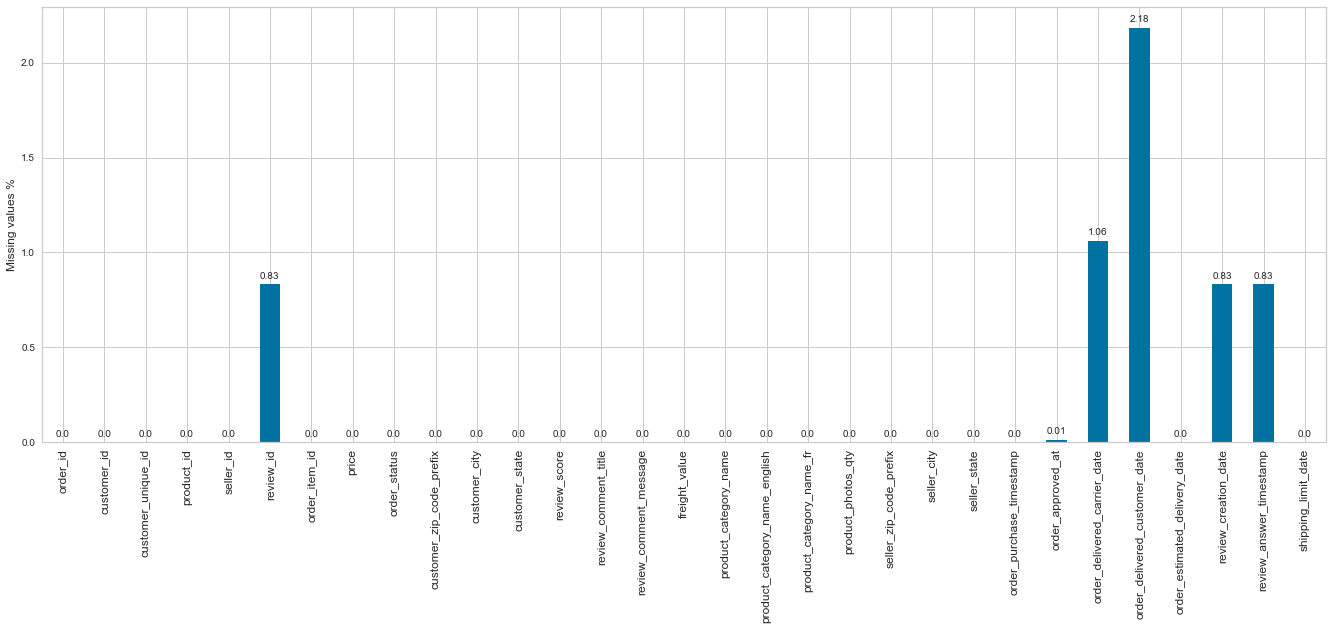

In [30]:
missing_rate = (df_olist.isna().sum()/df_olist.shape[0])*100
missing_rate = pd.DataFrame(missing_rate)
ax = missing_rate.plot.bar(figsize=(23,8))

ax.set_ylabel("Missing values %", fontsize=12)

plt.xticks(rotation='90', fontsize=12)

plt.legend().set_visible(False)


# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.annotate(np.round(p.get_height(),decimals=2),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 8),
                textcoords='offset points',
                fontsize = 10,
                )

In [31]:
df_olist.shape

(113314, 31)

Agréger les données du DataFrame df_payment par 'order_id'

In [32]:
# Avoir une ligne de commande pour df_payment
df_olist_payement = df_payment.copy()
df_olist_payement = df_olist_payement.sort_values(by=['order_id' , 'payment_sequential'])
df_olist_payement = df_olist_payement.drop_duplicates(subset ="order_id", keep = 'last')

df_olist_payement['nb_payment_installments'] = df_olist_payement['payment_installments']
df_olist_payement['total_payment']           = df_payment.groupby(['order_id'])['payment_value'].sum().values

#Supprimer les colonnes suivantes : payment_sequential,	payment_type,	payment_installments,	payment_value
df_olist_payement.drop(['payment_type',	'payment_installments',	'payment_value'],axis=1, inplace=True)
df_olist_payement

order_id  payment_sequential  \
85283  00010242fe8c5a6d1ba2dd792cb16214                   1   
2499   00018f77f2f0320c557190d7a144bdd3                   1   
12393  000229ec398224ef6ca0657da4fc703e                   1   
32971  00024acbcdf0a6daa1e931b038114c75                   1   
98711  00042b26cf59d7ce69dfabb4e55b4fd9                   1   
...                                 ...                 ...   
69123  fffc94f6ce00a00581880bf54a75a037                   1   
2776   fffcd46ef2263f404302a634eb57f7eb                   1   
58888  fffce4705a9662cd70adb13d4a31832d                   1   
37089  fffe18544ffabc95dfada21779c9644f                   1   
1235   fffe41c64501cc87c801fd61db3f6244                   1   

       nb_payment_installments  total_payment  
85283                        2          72.19  
2499                         3         259.83  
12393                        5         216.87  
32971                        2          25.78  
98711                        3         218.04  
...                        ...            ...  
69123                        1         343.40  
2776                         1         386.53  
58888                        3         116.85  
37089                        3          64.71  
1235                         1          55.79  

[99440 rows x 4 columns]

Agréger les données par commande

In [33]:
df_olist = df_olist.sort_values(by=['order_id' , 'order_item_id'])

df_olist_order = df_olist.copy()

# Supprimer les lignes dupliquées
df_olist_order = df_olist_order.drop_duplicates(subset ="order_id", keep = 'last')

# grouper dataframe par 'order_id'
df_olist_order['order_item_id'] = df_olist.groupby(['order_id'])['order_item_id'].count().values
df_olist_order['price'] = df_olist.groupby(['order_id'])['price'].sum().values
df_olist_order['freight_value'] = df_olist.groupby(['order_id'])['freight_value'].sum().values
df_olist_order['review_score'] = np.round(df_olist.groupby(['order_id'])['review_score'].mean().values).astype(int)
df_olist_order['product_photos_qty'] = np.round(df_olist.groupby(['order_id'])['product_photos_qty'].mean().values).astype(int)

df_olist_order = df_olist_order.merge(df_olist_payement, on='order_id', how='left')

df_olist_order.head(5)

order_id                       customer_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  3ce436f183e68e07877b285a838db11a   
1  00018f77f2f0320c557190d7a144bdd3  f6dd3ec061db4e3987629fe6b26e5cce   
2  000229ec398224ef6ca0657da4fc703e  6489ae5e4333f3693df5ad4372dab6d3   
3  00024acbcdf0a6daa1e931b038114c75  d4eb9395c8c0431ee92fce09860c5a06   
4  00042b26cf59d7ce69dfabb4e55b4fd9  58dbd0b2d70206bf40e62cd34e84d795   

                 customer_unique_id                        product_id  \
0  871766c5855e863f6eccc05f988b23cb  4244733e06e7ecb4970a6e2683c13e61   
1  eb28e67c4c0b83846050ddfb8a35d051  e5f2d52b802189ee658865ca93d83a8f   
2  3818d81c6709e39d06b2738a8d3a2474  c777355d18b72b67abbeef9df44fd0fd   
3  af861d436cfc08b2c2ddefd0ba074622  7634da152a4610f1595efa32f14722fc   
4  64b576fb70d441e8f1b2d7d446e483c5  ac6c3623068f30de03045865e4e10089   

                          seller_id                         review_id  \
0  48436dade18ac8b2bce089ec2a041202  97ca439bc427b48bc1cd7177abe71365   
1  dd7ddc04e1b6c2c614352b383efe2d36  7b07bacd811c4117b742569b04ce3580   
2  5b51032eddd242adc84c38acab88f23d  0c5b33dea94867d1ac402749e5438e8b   
3  9d7a1d34a5052409006425275ba1c2b4  f4028d019cb58564807486a6aaf33817   
4  df560393f3a51e74553ab94004ba5c87  940144190dcba6351888cafa43f3a3a5   

   order_item_id  price order_status  customer_zip_code_prefix  ...  \
0              1  58.90    delivered                     28013  ...   
1              1 239.90    delivered                     15775  ...   
2              1 199.00    delivered                     35661  ...   
3              1  12.99    delivered                     12952  ...   
4              1 199.90    delivered                     13226  ...   

    order_approved_at order_delivered_carrier_date  \
0 2017-09-13 09:45:35          2017-09-19 18:34:16   
1 2017-04-26 11:05:13          2017-05-04 14:35:00   
2 2018-01-14 14:48:30          2018-01-16 12:36:48   
3 2018-08-08 10:10:18          2018-08-10 13:28:00   
4 2017-02-04 14:10:13          2017-02-16 09:46:09   

   order_delivered_customer_date order_estimated_delivery_date  \
0            2017-09-20 23:43:48                    2017-09-29   
1            2017-05-12 16:04:24                    2017-05-15   
2            2018-01-22 13:19:16                    2018-02-05   
3            2018-08-14 13:32:39                    2018-08-20   
4            2017-03-01 16:42:31                    2017-03-17   

  review_creation_date  review_answer_timestamp shipping_limit_date  \
0           2017-09-21      2017-09-22 10:57:03 2017-09-19 09:45:35   
1           2017-05-13      2017-05-15 11:34:13 2017-05-03 11:05:13   
2           2018-01-23      2018-01-23 16:06:31 2018-01-18 14:48:30   
3           2018-08-15      2018-08-15 16:39:01 2018-08-15 10:10:18   
4           2017-03-02      2017-03-03 10:54:59 2017-02-13 13:57:51   

  payment_sequential nb_payment_installments  total_payment  
0               1.00                    2.00          72.19  
1               1.00                    3.00         259.83  
2               1.00                    5.00         216.87  
3               1.00                    2.00          25.78  
4               1.00                    3.00         218.04  

[5 rows x 34 columns]

Remplir les valeurs manquantes du dataframe df_olist_order suite à la jointure ci-dessus 

In [34]:
df_olist_order.isna().sum()

order_id                            0
customer_id                         0
customer_unique_id                  0
product_id                          0
seller_id                           0
review_id                         749
order_item_id                       0
price                               0
order_status                        0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
review_score                        0
review_comment_title                0
review_comment_message              0
freight_value                       0
product_category_name               0
product_category_name_english       0
product_category_name_fr            0
product_photos_qty                  0
seller_zip_code_prefix              0
seller_city                         0
seller_state                        0
order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date     1009
order_delive

Supprimer la ligne avec la colonne 'nb_payment_installments' à NaN

In [35]:
df_olist_order = df_olist_order[df_olist_order['nb_payment_installments'].notna()]

Agréger les données clients par id unique du client

In [36]:
df_olist_order = df_olist_order.sort_values(by=['customer_unique_id' , 'order_purchase_timestamp'] ,ascending=True)

df_olist_client = df_olist_order.copy()

df_olist_client = df_olist_client.drop_duplicates(subset ="customer_unique_id", keep = 'last')

# grouper dataframe par 'customer_unique_id'
df_olist_client['nb_item'] = df_olist_order.groupby(['customer_unique_id'])['order_item_id'].sum().values
df_olist_client['price'] = df_olist_order.groupby(['customer_unique_id'])['price'].sum().values
df_olist_client['total_payment'] = df_olist_order.groupby(['customer_unique_id'])['total_payment'].sum().values
df_olist_client['nb_payment_installments'] = df_olist_order.groupby(['customer_unique_id'])['nb_payment_installments'].mean().values
df_olist_client['freight_value'] = df_olist_order.groupby(['customer_unique_id'])['freight_value'].sum().values
df_olist_client['review_score'] = np.round(df_olist_order.groupby(['customer_unique_id'])['review_score'].mean().values).astype(int)
df_olist_client['product_photos_qty'] = np.round(df_olist_order.groupby(['customer_unique_id'])['product_photos_qty'].mean().values).astype(int)
df_olist_client['nb_order'] = df_olist_order.groupby(['customer_unique_id'])['order_id'].count().values
df_olist_client.drop(['order_id', 'customer_id', 'product_id', 'seller_id', 'review_id', 'order_item_id',
                             'review_comment_title',	'review_comment_message'],axis=1, inplace=True)

df_olist_client.head(5)

customer_unique_id  price order_status  \
87338  0000366f3b9a7992bf8c76cfdf3221e2 129.90    delivered   
20578  0000b849f77a49e4a4ce2b2a4ca5be3f  18.90    delivered   
68939  0000f46a3911fa3c0805444483337064  69.00    delivered   
25028  0000f6ccb0745a6a4b88665a16c9f078  25.99    delivered   
83852  0004aac84e0df4da2b147fca70cf8255 180.00    delivered   

       customer_zip_code_prefix customer_city customer_state  review_score  \
87338                      7787       cajamar             SP             5   
20578                      6053        osasco             SP             4   
68939                     88115      sao jose             SC             3   
25028                     66812         belem             PA             4   
83852                     18040      sorocaba             SP             5   

       freight_value product_category_name product_category_name_english  ...  \
87338          12.00       cama_mesa_banho                bed_bath_table  ...   
20578           8.29          beleza_saude                 health_beauty  ...   
68939          17.22             papelaria                    stationery  ...   
25028          17.63             telefonia                     telephony  ...   
83852          16.89             telefonia                     telephony  ...   

      order_delivered_customer_date  order_estimated_delivery_date  \
87338           2018-05-16 20:48:37                     2018-05-21   
20578           2018-05-10 18:02:42                     2018-05-15   
68939           2017-04-05 14:38:47                     2017-04-07   
25028           2017-11-01 21:23:05                     2017-11-13   
83852           2017-11-27 23:08:56                     2017-12-05   

       review_creation_date review_answer_timestamp shipping_limit_date  \
87338            2018-05-17     2018-05-21 13:44:48 2018-05-15 11:11:18   
20578            2018-05-11     2018-05-11 22:29:25 2018-05-11 17:56:33   
68939            2017-04-06     2017-04-07 01:19:44 2017-03-15 21:05:03   
25028            2017-11-02     2017-11-03 00:17:51 2017-10-18 21:49:17   
83852            2017-11-28     2017-12-02 22:29:35 2017-11-22 20:06:52   

      payment_sequential nb_payment_installments total_payment nb_item  \
87338               1.00                    8.00        141.90       1   
20578               1.00                    1.00         27.19       1   
68939               1.00                    8.00         86.22       1   
25028               1.00                    4.00         43.62       1   
83852               1.00                    6.00        196.89       1   

      nb_order  
87338        1  
20578        1  
68939        1  
25028        1  
83852        1  

[5 rows x 28 columns]

# **<font color='blue'/>Analyse exploratoire des données**

---



Analyse univariée des prix

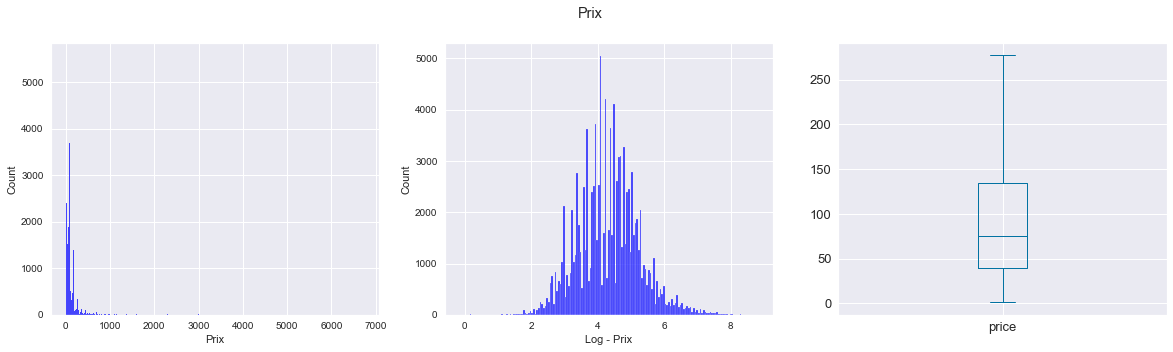

In [37]:
sns.set_style("darkgrid")

plt.figure(figsize=(20,5))

plt.subplot(131)
fig = sns.histplot(data=df_olist, x=df_olist['price'], color='blue')

fig.set_xlabel("Prix")

plt.subplot(132)
ax = sns.histplot(data=df_olist, x=np.log(df_olist['price']), color='blue')
ax.set_xlabel("Log - Prix")

plt.subplot(133)
ax = df_olist['price'].plot.box(color='b',showfliers=False)

plt.suptitle("Prix")

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

Graphique des scores des commandes

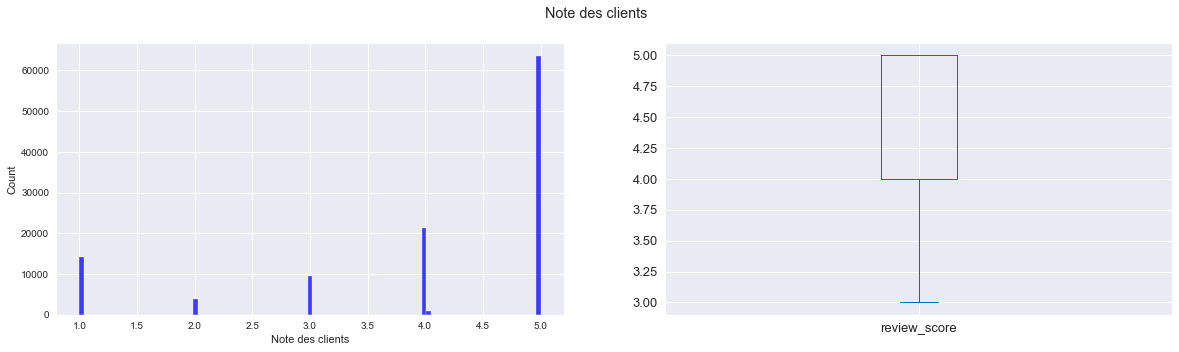

In [38]:
plt.figure(figsize=(20,5))

plt.subplot(121)
fig = sns.histplot(data=df_olist, x=df_olist['review_score'], color='blue')

fig.set_xlabel("Note des clients")

plt.subplot(122)
ax = df_olist['review_score'].plot.box(color='b',showfliers=False)

plt.suptitle("Note des clients")

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

Graphique des frais de port

C:\Users\sweet\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


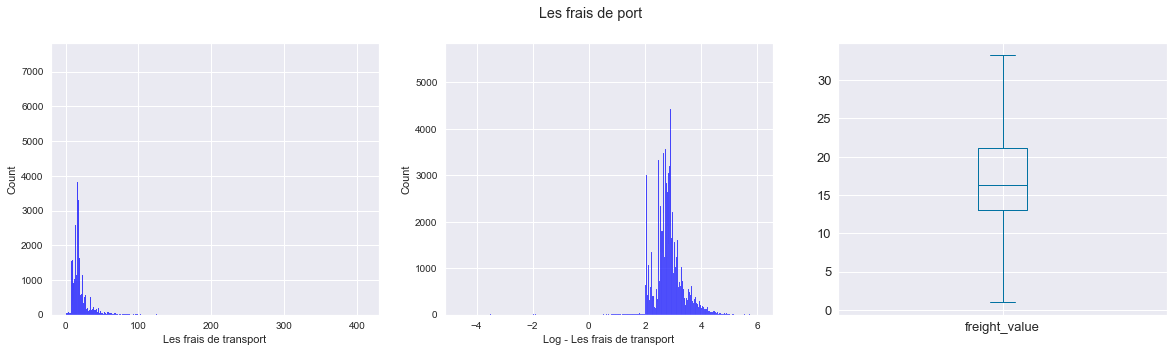

In [39]:
plt.figure(figsize=(20,5))

plt.subplot(131)
fig = sns.histplot(data=df_olist, x=df_olist['freight_value'], color='blue')

fig.set_xlabel("Les frais de transport")

plt.subplot(132)
ax = sns.histplot(data=df_olist, x=np.log(df_olist['freight_value']), color='blue')
ax.set_xlabel("Log - Les frais de transport")

plt.subplot(133)
ax = df_olist['freight_value'].plot.box(color='b',showfliers=False)

plt.suptitle("Les frais de port")

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

Graphique type de paiement

C:\Users\sweet\AppData\Local\Temp/ipykernel_9552/2830204132.py:34: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(y, loc=[-0.32,0.5], labels=['%s - %1.2f%%' % (l, s) for l, s in zip(labels, (x/sum(x))*100)],fontsize=13,facecolor='#fbf8f8')


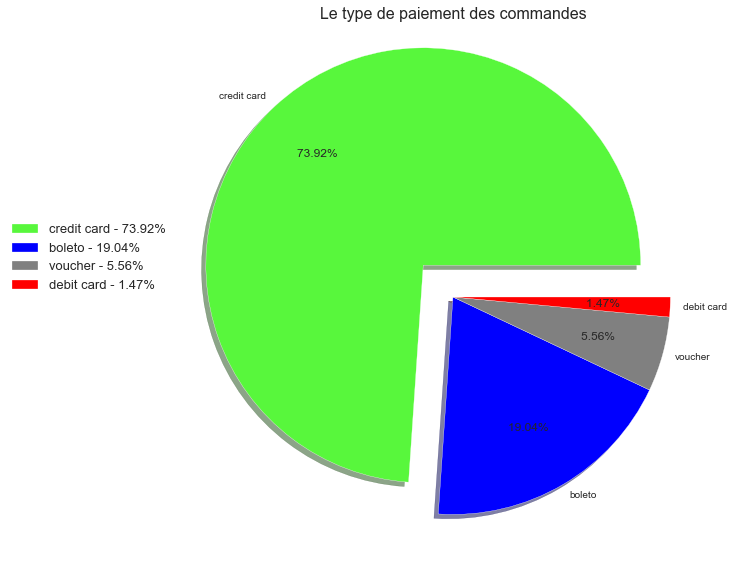

In [40]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if (val/total)>0.01 : 
          # return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
          return '{p:.2f}% '.format(p=pct)
    return my_autopct
    
colors = ['#58F73C', 'blue', 'gray', 'red', 'orange', '#F73CA5', '#FFFC1E', 'lightblue', 
          '#FF771E','pink', 'cadetblue', 'lightgray', '#f48100', 'yellow']

# Merger les deux dataframes df_payment et df_order
df_order_payment = df_order.merge(df_payment, on='order_id', how='outer')

plt.figure(figsize = (10, 10))

data_type = df_order_payment.groupby(['payment_type']).agg({"order_id" : "count"}).reset_index()
data_type = data_type[data_type['order_id']>3].sort_values(by='order_id', ascending=False)
y = data_type['payment_type'].str.replace('_', ' ')
x = data_type['order_id']
labels = y

plt.pie(x, labels=y,
           explode = [0.2, 0, 0, 0],
           autopct = make_autopct(x),
           pctdistance = 0.7, 
           labeldistance = 1.06,
           colors = colors,
           shadow = True)

plt.title('Le type de paiement des commandes', fontsize=16)

plt.legend(y, loc=[-0.32,0.5], labels=['%s - %1.2f%%' % (l, s) for l, s in zip(labels, (x/sum(x))*100)],fontsize=13,facecolor='#fbf8f8')

Graphique du statut des commandes

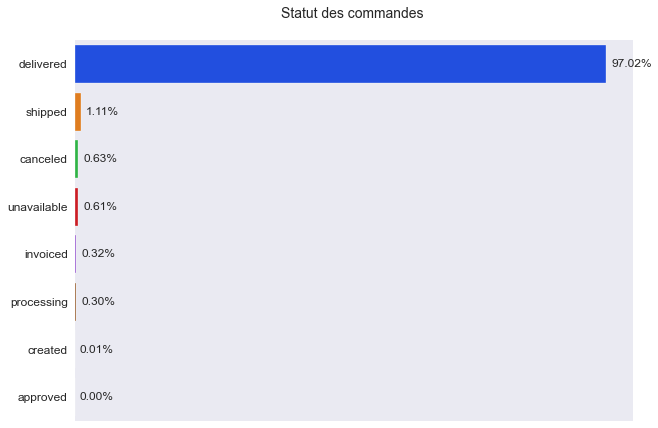

In [41]:
data_status = df_order.groupby(['order_status']).agg({"order_id" : "count"}).reset_index()
data_status.rename(columns = {"order_id":"nb_status"}, inplace=True)
data_status = data_status.sort_values(by='nb_status', ascending=False).reset_index()

y_values = data_status['order_status']
x_values = data_status['nb_status']

# Graphique des caractéristiques les plus importantes
fig, ax = plt.subplots(figsize=(10,7))
# fig.patch.set_facecolor('#F5F2F2')

ax = sns.barplot(x=(x_values/x_values.sum())*100, y=y_values, data=data_status, palette="bright")

# Ajouter les annotations sur les barres
for p in ax.patches:
    ax.annotate("%.2f" % p.get_width()+'%', xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

ax.set_title("Statut des commandes \n", fontsize=14)
ax.set_xlabel("")
ax.set_ylabel("")
plt.yticks(fontsize=12)
ax.axes.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)

Les villes et les états avec le plus de clients

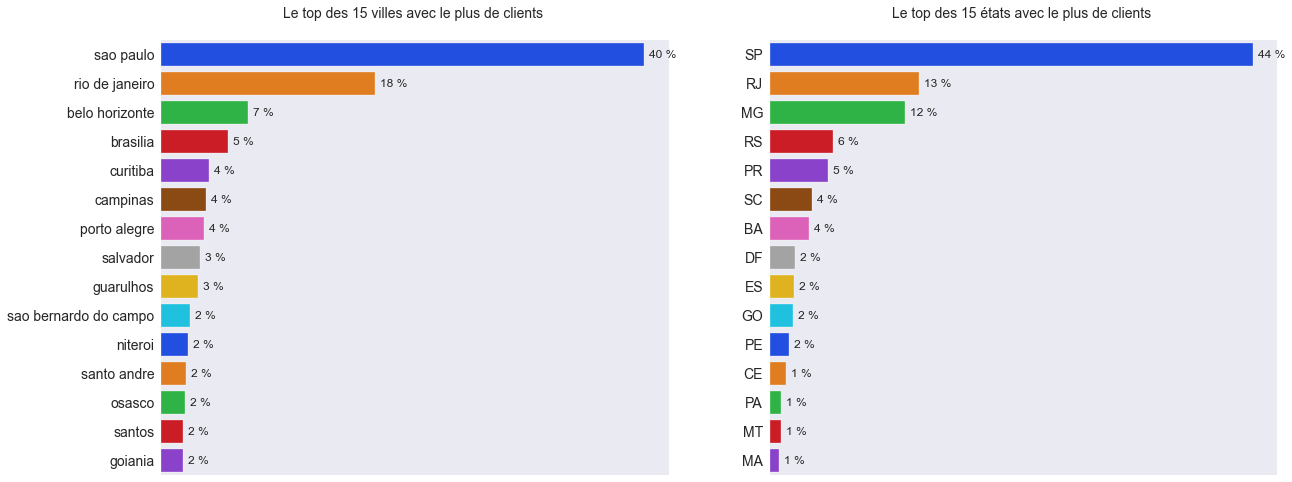

In [42]:
data_city = df_customer.groupby(['customer_city']).agg({"customer_unique_id" : "count"}).reset_index()
data_city.rename(columns = {"customer_unique_id":"total_city"}, inplace=True)
data_city = data_city.sort_values(by='total_city', ascending=False).head(15)

x_city = (data_city['total_city']/data_city['total_city'].sum()*100)
y_city = data_city['customer_city']

data_state = df_customer.groupby(['customer_state']).agg({"customer_unique_id" : "count"}).reset_index()
data_state.rename(columns = {"customer_unique_id":"total_state"}, inplace=True)
data_state = data_state.sort_values(by='total_state', ascending=False).head(15)

x_state = (data_state['total_state']/data_state['total_state'].sum())*100
y_state = data_state['customer_state']

# Graphique des caractéristiques les plus importantes
fig, ax = plt.subplots(figsize=(20,8))
# fig.patch.set_facecolor('#F5F2F2')

plt.subplot(121)
ax = sns.barplot(x=x_city, y=y_city, data=data_city, palette="bright")

# Ajouter les annotations sur les barres
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width()+' %', xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

ax.set_title("Le top des 15 villes avec le plus de clients \n", fontsize=14)
ax.set_xlabel("")
ax.set_ylabel("")
plt.yticks(fontsize=14)
ax.axes.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)

plt.subplot(122)
ax = sns.barplot(x=x_state, y=y_state, data=data_state, palette="bright")
# Ajouter les annotations sur les barres
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width()+' %', xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

# Ajouter des textes aux labels, titre etc.
ax.set_title("Le top des 15 états avec le plus de clients \n", fontsize=14)
ax.set_xlabel("")
ax.set_ylabel("")
plt.yticks(fontsize=14)
ax.axes.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
plt.show()

Le nombre de nouveaux clients par mois

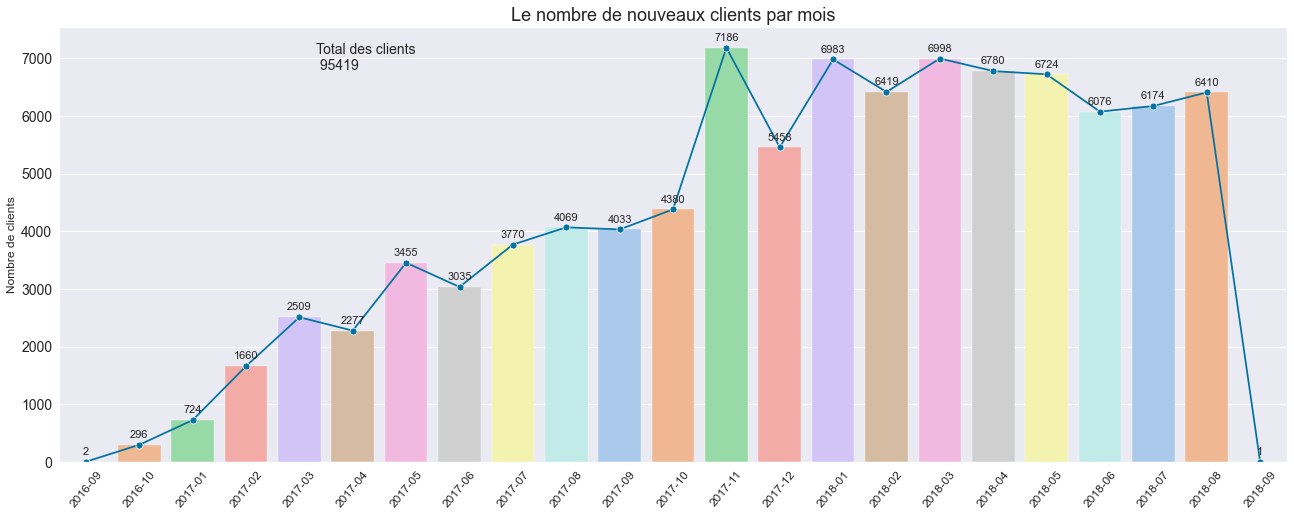

In [43]:
df_olist_evol = df_olist_client.copy()
df_olist_evol = df_olist_evol.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'], ascending=False)
df_olist_evol = df_olist_evol.drop_duplicates(subset='customer_unique_id', keep='first')
df_olist_evol["order_purchase_timestamp"] = df_olist_evol["order_purchase_timestamp"].dt.strftime('%Y-%m')
data_evol = df_olist_evol.groupby(['order_purchase_timestamp']).agg({"customer_unique_id" : "count"}).reset_index()

data_evol.rename(columns = {"customer_unique_id":"nb_client"}, inplace=True)

x = data_evol['order_purchase_timestamp']
y = data_evol['nb_client']

fig, ax = plt.subplots(figsize=(22,8))

sns.lineplot(x= x, y = y, data = data_evol, palette="husl",marker='o')
sns.barplot(x=x, y=y, data=data_evol, palette="pastel")

sns.axes_style("darkgrid")


# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    plt.annotate("%.0f" % p.get_height(),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize = 11,
                #  rotation='vertical',
                )

ax.set_ylabel('Nombre de clients', fontsize=12)

plt.xticks(rotation='50', fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('', fontsize=16)
ax.text(p.get_x()/5, 6800,'Total des clients\n %s' % df_olist_evol['customer_unique_id'].unique().size, fontsize = 14)

plt.title('Le nombre de nouveaux clients par mois', fontsize=18)

plt.show()

Le nombre de nouveaux vendeurs par mois

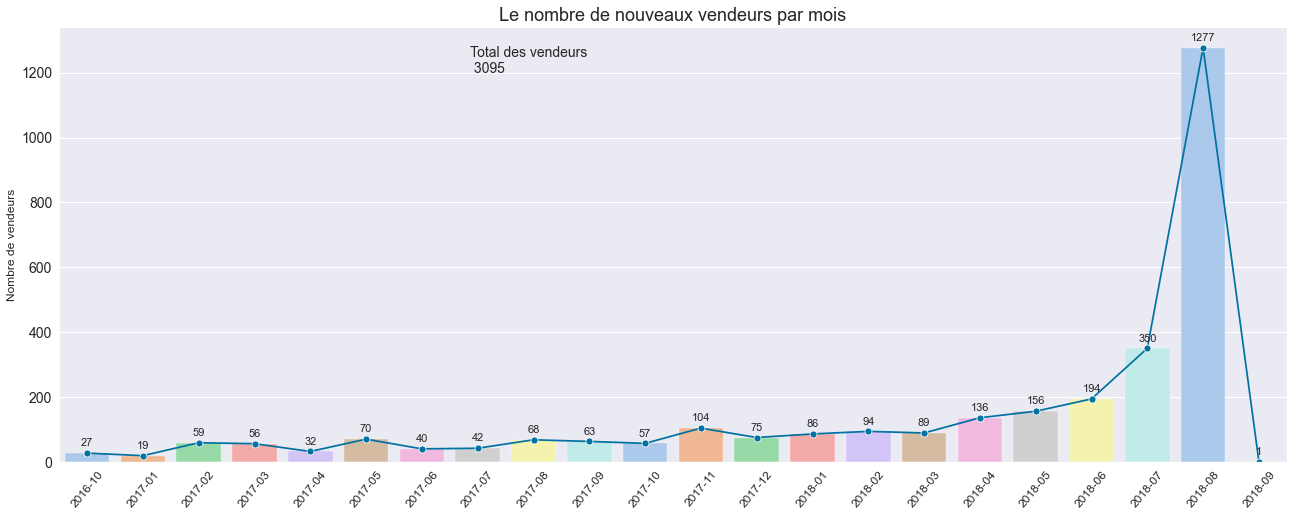

In [44]:
df_olist_seller = df_olist.copy()
df_olist_seller = df_olist_seller.sort_values(by=['seller_id', 'order_purchase_timestamp'], ascending=False)
df_olist_seller = df_olist_seller.drop_duplicates(subset='seller_id', keep='first')
df_olist_seller["order_purchase_timestamp"] = df_olist_seller["order_purchase_timestamp"].dt.strftime('%Y-%m')
data_evol = df_olist_seller.groupby(['order_purchase_timestamp']).agg({"seller_id" : "count"}).reset_index()

data_evol.rename(columns = {"seller_id":"nb_seller"}, inplace=True)

x = data_evol['order_purchase_timestamp']
y = data_evol['nb_seller']

fig, ax = plt.subplots(figsize=(22,8))

sns.lineplot(x= x, y = y, data = data_evol, palette="bright",marker='o')
sns.barplot(x=x, y=y, data=data_evol, palette="pastel")

sns.axes_style("darkgrid")


# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    plt.annotate("%.0f" % p.get_height(),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize = 11,
                #  rotation='vertical',
                )

ax.set_ylabel('Nombre de vendeurs', fontsize=12)

plt.xticks(rotation='50', fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('', fontsize=16)
# add text
ax.text(p.get_x()/3, 1200,'Total des vendeurs\n %s' % df_olist['seller_id'].unique().size, fontsize = 14)

plt.title('Le nombre de nouveaux vendeurs par mois', fontsize=18)

plt.show()

Nombre de commandes par mois

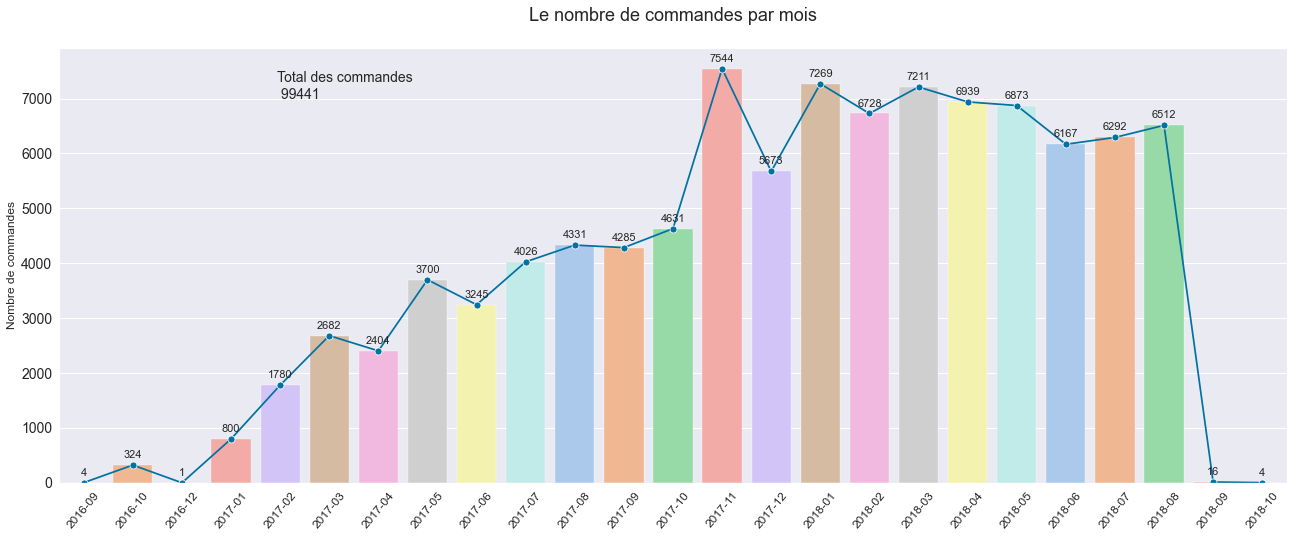

In [45]:
df_olist_order_menth = df_order.copy()
df_olist_order_menth["order_purchase_timestamp"] = df_olist_order_menth["order_purchase_timestamp"].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

df_olist_order_menth["order_purchase_timestamp"] = df_olist_order_menth["order_purchase_timestamp"].dt.strftime('%Y-%m')
data_order = df_olist_order_menth.groupby(['order_purchase_timestamp']).agg({"order_id" : "count"}).reset_index()

data_order.rename(columns = {"order_id":"nb_order"}, inplace=True)

x = data_order['order_purchase_timestamp']
y = data_order['nb_order']

fig, ax = plt.subplots(figsize=(22,8))

sns.lineplot(x= x, y = y, data = data_order, palette="husl",marker='o')
sns.barplot(x=x, y=y, data=data_order, palette="pastel")

# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    plt.annotate("%.0f" % p.get_height(),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize = 11,
                #  rotation='vertical',
                )

ax.set_ylabel('Nombre de commandes', fontsize=12)

plt.xticks(rotation='50', fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('', fontsize=16)
# add text
ax.text(p.get_x()/6, 7000,'Total des commandes\n %s' % data_order['nb_order'].sum(), fontsize = 14)

plt.title('Le nombre de commandes par mois\n', fontsize=18)

plt.show()

Prix et frais de port des commandes par mois

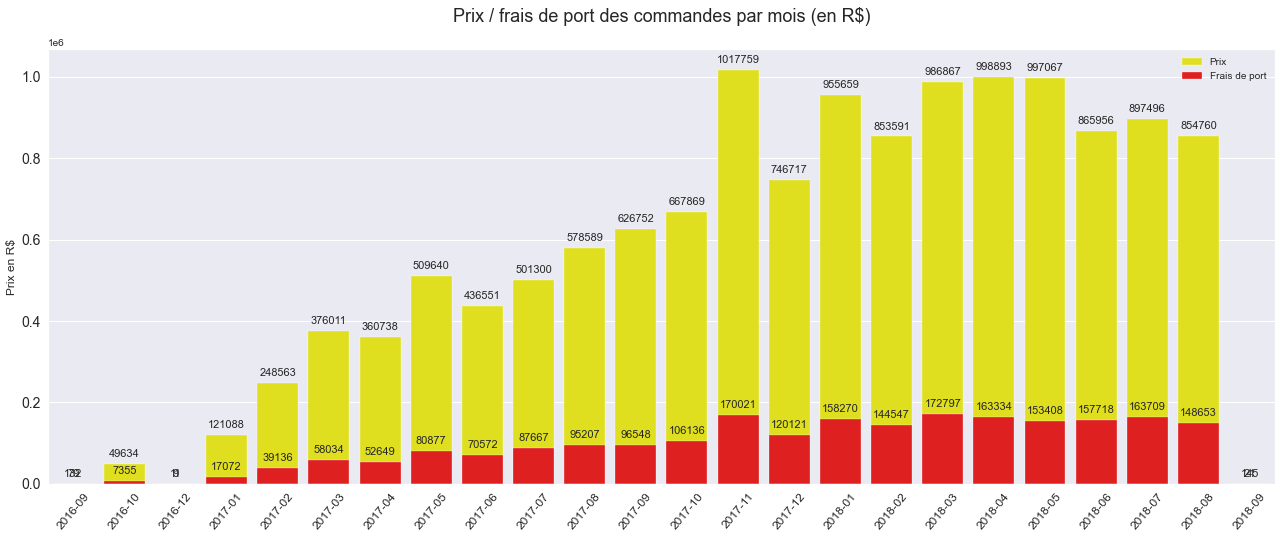

In [46]:
sns.set_style("darkgrid")

df_olist_price_ship = df_olist_order.copy()
df_olist_price_ship["order_purchase_timestamp"] = df_olist_price_ship["order_purchase_timestamp"].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')
df_olist_price_ship["order_purchase_timestamp"] = df_olist_price_ship["order_purchase_timestamp"].dt.strftime('%Y-%m')

data_price_ship = df_olist_price_ship.groupby(['order_purchase_timestamp']).agg({"price" : "sum", "freight_value" : "sum"}).reset_index()
data_price_ship
data_price_ship.rename(columns = {"price":"total_price"}, inplace=True)
data_price_ship.rename(columns = {"freight_value":"total_freight"}, inplace=True)

x = data_price_ship['order_purchase_timestamp']
y = data_price_ship['total_price']
y_bis = data_price_ship['total_freight']

fig, ax = plt.subplots(figsize=(22,8))

# sns.lineplot(x= x, y = y, data = data_price_ship, palette="husl",marker='o')
sns.barplot(x=x, y=y, data=data_price_ship, color='yellow',label = 'Prix')
# sns.lineplot(x= x, y = y_bis, data = data_price_ship, palette="husl",marker='o')
sns.barplot(x=x, y=y_bis, data=data_price_ship, color='red', label = 'Frais de port')

# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    plt.annotate("%.0f" % p.get_height(),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize = 11,
                #  rotation='vertical',
                )

ax.set_ylabel('Prix en R$', fontsize=12)

plt.xticks(rotation='50', fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('', fontsize=16)

plt.title('Prix / frais de port des commandes par mois (en R$)\n', fontsize=18)
plt.legend()

plt.show()

In [47]:
df_olist_price_ship = df_olist_order.copy()

df_olist_price_ship["order_purchase_timestamp"] = df_olist_price_ship["order_purchase_timestamp"].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')
df_olist_price_ship["order_purchase_timestamp"] = df_olist_price_ship["order_purchase_timestamp"].dt.strftime('%Y-%m-%d')

data_price_ship = df_olist_price_ship.groupby(['order_purchase_timestamp']).agg({"price" : "sum", "freight_value" : "sum"}).reset_index()
data_price_ship
data_price_ship.rename(columns = {"price":"total_price"}, inplace=True)
data_price_ship.rename(columns = {"freight_value":"total_freight"}, inplace=True)

x = data_price_ship['order_purchase_timestamp']
y = data_price_ship['total_price']
y_bis = data_price_ship['total_freight']


fig=go.Figure()

fig.add_trace(go.Scatter(x= x, y = y, name='Prix'))
fig.add_trace(go.Scatter(x= x, y = y_bis, name='frais de port'))

fig.update_layout(
    title="Prix / frais de port des commandes (en R$)", title_x=0.5,
    xaxis_title="Date",
    yaxis_title="Prix (R$)\n",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#7f7f7f"
    )
)

fig.show()

La fréquence des commandes

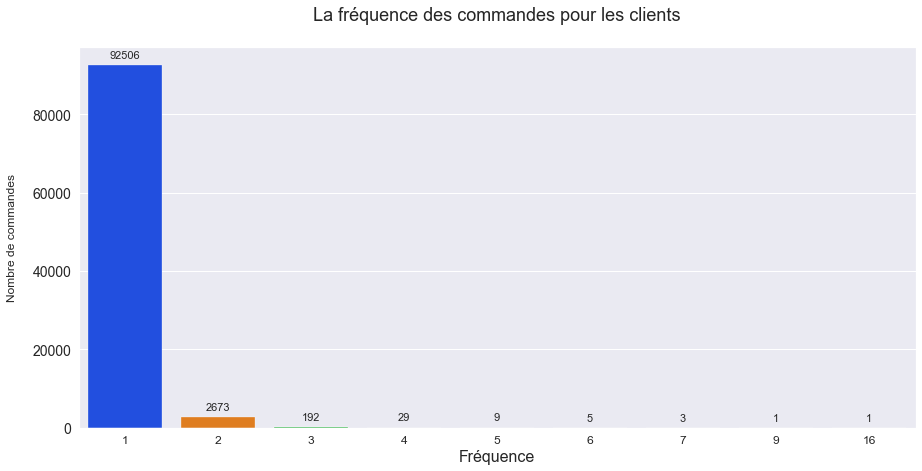

In [48]:
df_olist_order_frequency = df_olist_client.copy()

data_frequency = df_olist_order_frequency.groupby(['nb_order']).agg({"customer_unique_id" : "count"}).reset_index()
data_frequency.rename(columns = {"customer_unique_id":"frequency"}, inplace=True)
data_frequency = data_frequency.sort_values(by='frequency', ascending=True)

x_frequency = data_frequency['nb_order']
y_frequency = data_frequency['frequency']

fig, ax = plt.subplots(figsize=(15,7))

# ax = sns.lineplot(x= x_frequency, y = y_frequency, data=data_frequency, palette="pastel",marker='o')
ax = sns.barplot(x=x_frequency, y=y_frequency, data=data_frequency, palette="bright")

# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    plt.annotate("%.0f" % p.get_height(),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize = 11,
                #  rotation='vertical',
                )

ax.set_ylabel('Nombre de commandes\n', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Fréquence', fontsize=16)

plt.title('La fréquence des commandes pour les clients\n', fontsize=18)

plt.show()

Le score des commandes

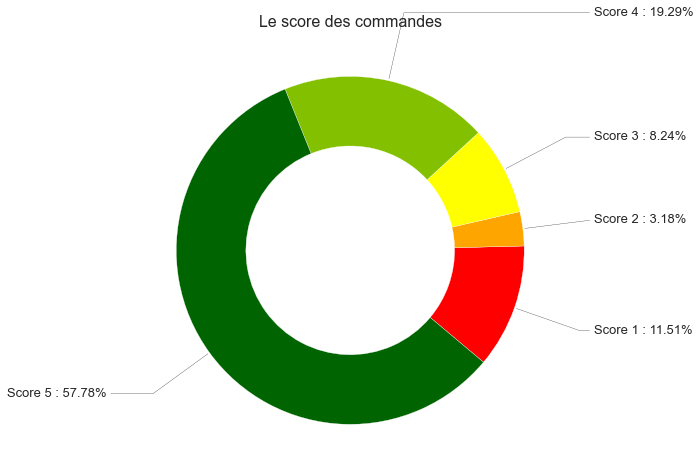

In [49]:
data_score = df_review.groupby(['review_score']).agg({"order_id" : "count"}).reset_index()
data_score.rename(columns = {"order_id":"nb_score"}, inplace=True)
data_score = data_score.sort_values(by='review_score').reset_index()

y_score = data_score['review_score']
x_score = data_score['nb_score']


fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

colors = ['red', 'orange', 'yellow', '#83c000', 'darkgreen']

kw = dict(arrowprops=dict(arrowstyle="-"),
          zorder=0, va="center",fontsize=13)

wedges, texts = plt.pie(x_score, wedgeprops=dict(width=0.4), startangle=-40, colors=colors)

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2 + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle}, color="0.1")
    ax.annotate('Score %s'%y_score[i]+' : '+np.round(((x_score[i]/sum(x_score))*100),2).astype(str)+'%',
                xy=(x, y), xytext=(1.4 * np.sign(x), 1.4 * y),
                horizontalalignment=horizontalalignment, **kw)


plt.title('Le score des commandes', fontsize=16)

# plt.legend(y_score, loc=[1.06, 0.22], labels=['%s : %1.2f%%' % (l, s) for l, s in zip(y, (x / sum(x)) * 100)],fontsize=14, facecolor='#fbf8f8')
plt.show()

Calculer la moyenne par catégorie

In [50]:
categorie = df_olist_order['product_category_name_fr'].unique()

df_categorie = pd.DataFrame(index=range(0,len(categorie)), columns = ['Categorie'])
df_categorie['Mean_Price'] = 0
df_categorie['Mean_Score'] = 0
df_categorie['Mean_Transport'] = 0

for i in range (len(categorie)):
  df_categorie['Categorie'][i] = categorie[i]
  df_categorie['Mean_Price'].values[i] = df_olist_order['price'][df_olist_order['product_category_name_fr'] == categorie[i]].mean()
  df_categorie['Mean_Score'].values[i] = df_olist_order['review_score'][df_olist_order['product_category_name_fr'] == categorie[i]].mean()
  df_categorie['Mean_Transport'].values[i] = df_olist_order['freight_value'][df_olist_order['product_category_name_fr'] == categorie[i]].mean()

C:\Users\sweet\AppData\Local\Temp/ipykernel_9552/668974830.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
df_categorie.sort_values(by='Mean_Price', ascending=False).head(10)

Categorie  Mean_Price  Mean_Score  \
56                                    des ordinateurs        1232           4   
66  petits appareils ménagers à la maison four et ...         632           4   
32                               Appareils ménagers 2         485           4   
51                         industrie agro et commerce         398           4   
43                             instruments de musique         307           4   
14                                   petits appareils         305           4   
71       préparateurs d'aliments de cuisine portables         283           3   
33                                    téléphonie fixe         276           3   
35                    Outils de construction Sécurité         245           3   
60                                      climatisation         218           4   

    Mean_Transport  
56              54  
66              36  
32              45  
51              32  
43              29  
14              25  
71              22  
33              21  
35              23  
60              26

Le top 15 des meilleurs catégories en terme de commandes

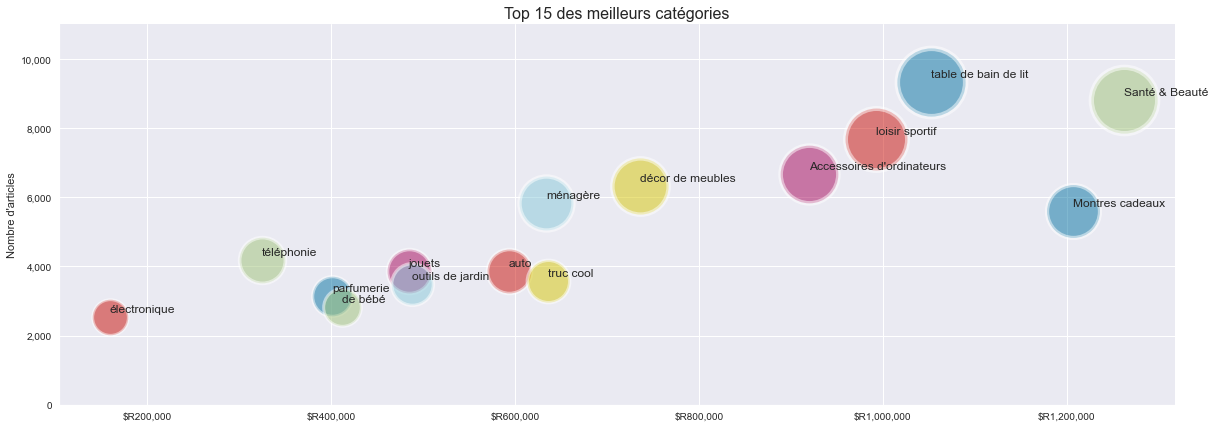

In [52]:
df_olist_order['order_purchase_year_month'] = df_olist_order['order_purchase_timestamp'].dt.strftime('%Y-%m')
df_product_category = df_olist_order.groupby("product_category_name_fr").agg({"order_purchase_year_month" : "count","price" : "sum"}).reset_index().sort_values(by="order_purchase_year_month", ascending=False).head(15)

fig, ax = plt.subplots(figsize=(20,7))

for product in df_product_category["product_category_name_fr"].unique():
    data = df_product_category[df_product_category["product_category_name_fr"] == product]
    sns.scatterplot(x = data['price'],y = data['order_purchase_year_month'], data=df_product_category ,
                    s=0.5*data['order_purchase_year_month']**1,alpha = 0.5, palette='bright')
    
for index, row in df_product_category.iterrows():
    ax.annotate(row['product_category_name_fr'],
                 (row['price'], row['order_purchase_year_month']),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha='left')

ax.set_xlabel("")
ax.set_ylabel("Nombre d'articles")
ax.set_title("Top 15 des meilleurs catégories",size=16)
ax.set_ylim(0,11000)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('$R{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

Moyenne des prix et les frais de port par catégorie

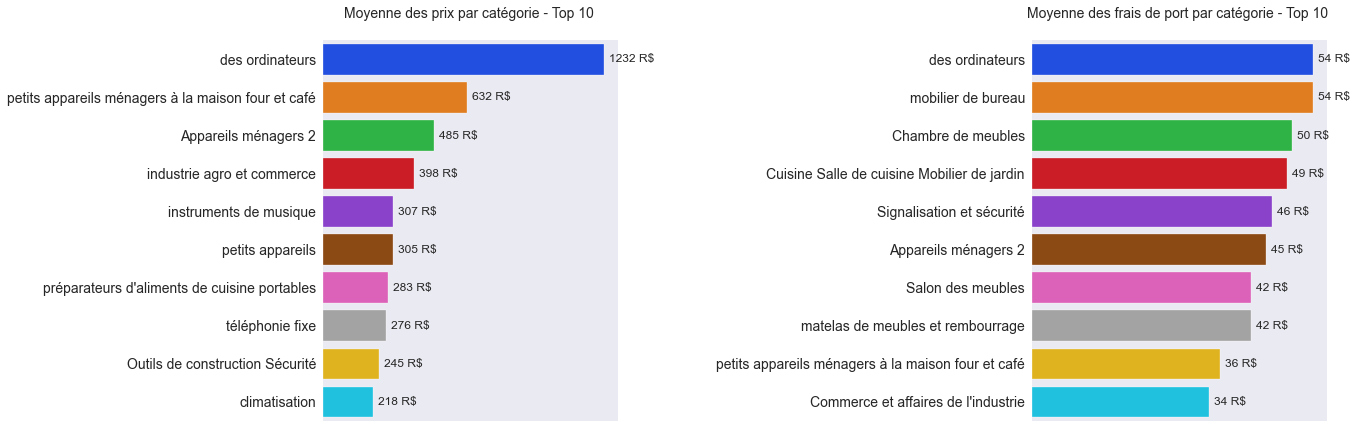

In [53]:
# Graphique des caractéristiques les plus importantes
fig, ax = plt.subplots(figsize=(18,7))
# fig.patch.set_facecolor('#F5F2F2')

plt.subplot(131)

df_categorie_prix = df_categorie.sort_values(by='Mean_Price', ascending=False).head(10)
x = df_categorie_prix['Mean_Price']
y = df_categorie_prix['Categorie']

ax = sns.barplot(x=x, y=y, data=data_city, palette="bright")

# Ajouter les annotations sur les barres
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width()+' R$', xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

ax.set_title("Moyenne des prix par catégorie - Top 10 \n", fontsize=14)
ax.set_xlabel("")
ax.set_ylabel("")
plt.yticks(fontsize=14)
ax.axes.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)


plt.subplot(133)

df_categorie_transport = df_categorie.sort_values(by='Mean_Transport', ascending=False).head(10)
x = df_categorie_transport['Mean_Transport']
y = df_categorie_transport['Categorie']

ax = sns.barplot(x=x, y=y, data=data_state, palette="bright")
# Ajouter les annotations sur les barres
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width()+' R$', xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

# Ajouter des textes aux labels, titre etc.
ax.set_title("Moyenne des frais de port par catégorie - Top 10 \n", fontsize=14)
ax.set_xlabel("")
ax.set_ylabel("")
plt.yticks(fontsize=14)
ax.axes.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
plt.show()

Graphique boxplot des prix par catégorie

Text(0.5, 0, 'Catégorie')

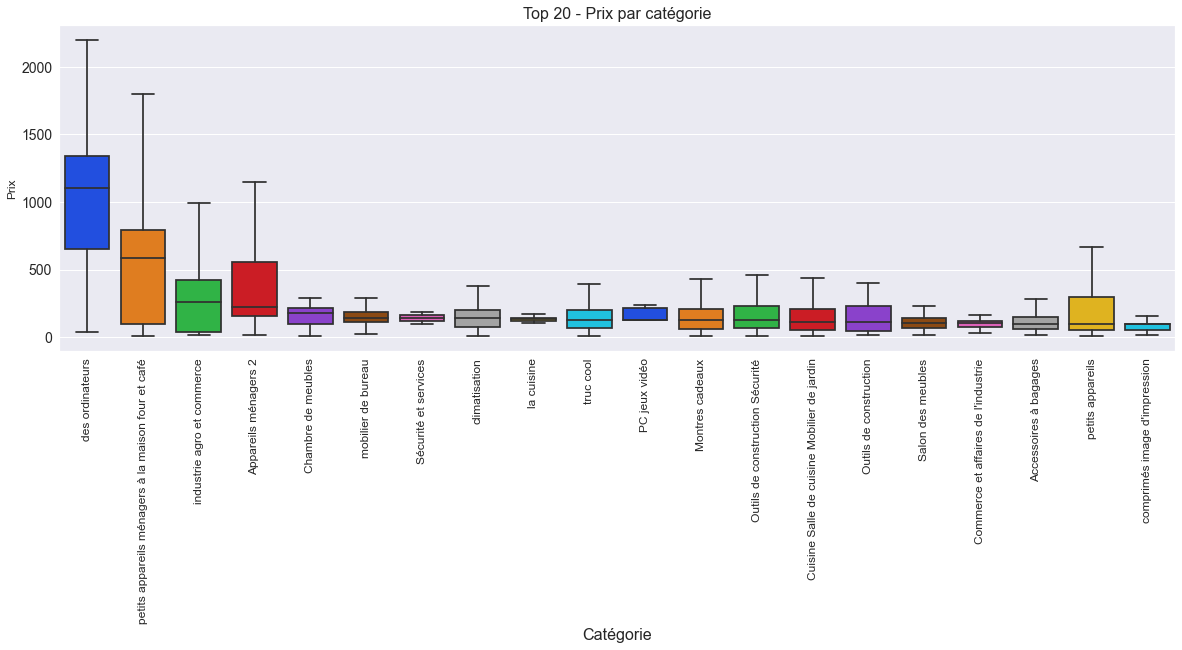

In [54]:
fig, ax = plt.subplots()

var_y = df_olist['price']

grouped = df_olist.loc[:,['product_category_name_fr', 'price']] \
    .groupby(['product_category_name_fr']) \
    .median() \
    .sort_values(by='price', ascending=False).head(20)



sns.boxplot(x= df_olist['product_category_name_fr'], y = df_olist['price'], data = df_olist, order=grouped.index,showfliers=False, palette='bright')

fig.set_size_inches(20, 6)
ax.set_ylabel('Prix', fontsize=12)
ax.set_title("Top 20 - Prix par catégorie", fontsize=16)

plt.xticks(rotation='90', fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Catégorie', fontsize=16)

Graphique boxplot des score par catégorie

Text(0.5, 0, 'Categorie')

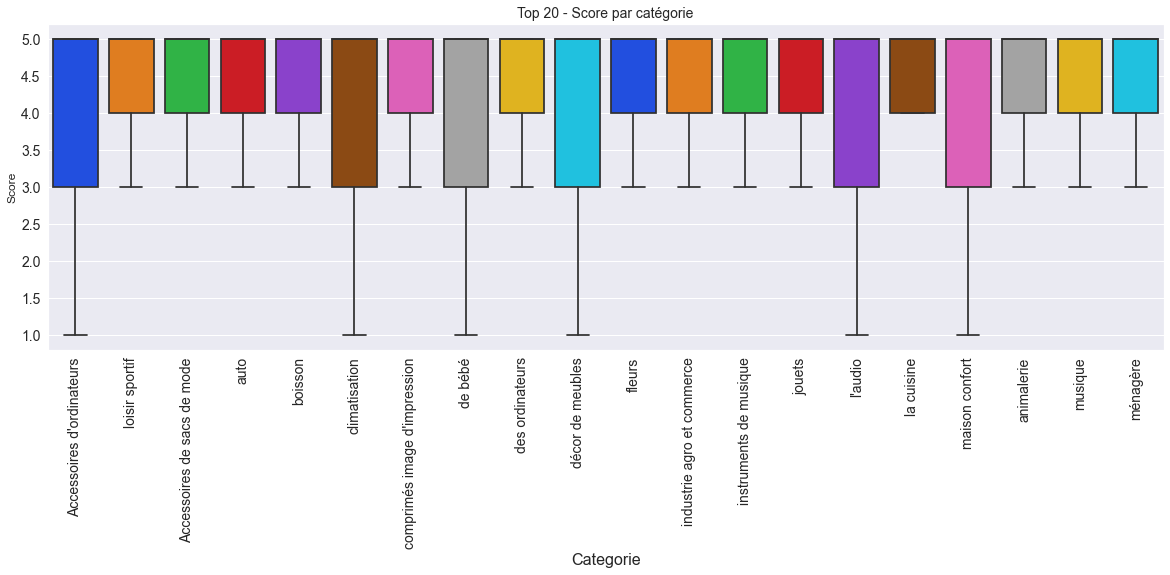

In [55]:
fig, ax = plt.subplots()

var_y = df_olist['review_score']

grouped = df_olist.loc[:,['product_category_name_fr', 'review_score']] \
    .groupby(['product_category_name_fr']) \
    .median() \
    .sort_values(by='review_score', ascending=(False)).head(20)



sns.boxplot(x= df_olist['product_category_name_fr'], y = df_olist['review_score'], data = df_olist, order=grouped.index,showfliers=False, palette='bright')

fig.set_size_inches(20, 6)
ax.set_ylabel('Score', fontsize=12)
ax.set_title("Top 20 - Score par catégorie", fontsize=14)

plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Categorie', fontsize=16)

Graphique boxplot des frais de transport par catégorie

Text(0.5, 0, 'Categorie')

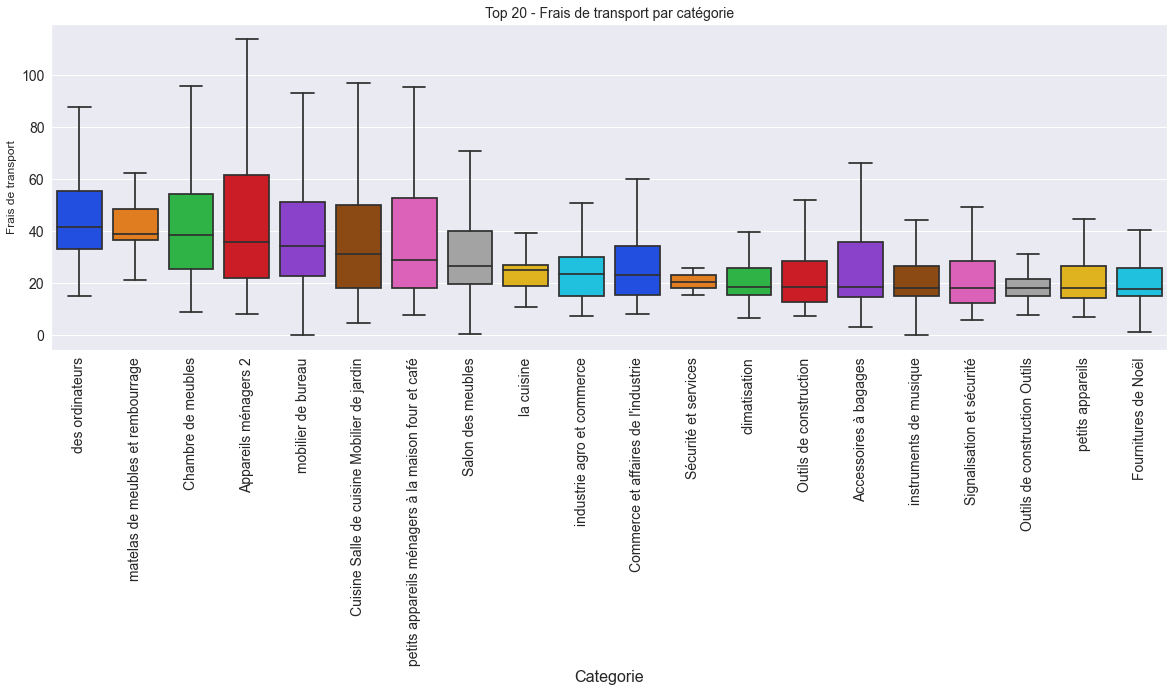

In [56]:
fig, ax = plt.subplots()

var_y = df_olist['freight_value']

grouped = df_olist.loc[:,['product_category_name_fr', 'freight_value']] \
    .groupby(['product_category_name_fr']) \
    .median() \
    .sort_values(by='freight_value', ascending=False).head(20)



sns.boxplot(x= df_olist['product_category_name_fr'], y = df_olist['freight_value'], data = df_olist, order=grouped.index,showfliers=False, palette='bright')

fig.set_size_inches(20, 6)
ax.set_ylabel('Frais de transport', fontsize=12)
ax.set_title("Top 20 - Frais de transport par catégorie", fontsize=14)

plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Categorie', fontsize=16)

Graphique pour identifier la corrélation entre 'price' et 'review_score'

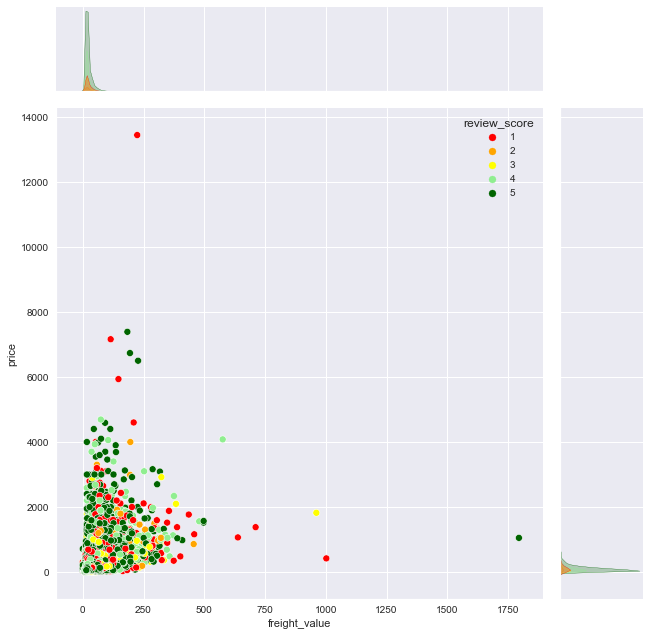

In [57]:
colors = ['red', 'orange', 'yellow', 'lightgreen', 'darkgreen']

sns.set_palette(sns.color_palette(colors))
sns.jointplot(x="freight_value", y="price", data=df_olist_client, height=9, hue='review_score',palette=colors)

Exporter DataFrame df_olist_client au format CSV

In [58]:
df_olist_client.to_csv('df_olist_client.csv', index = False)